<a href="https://colab.research.google.com/github/kdmalc/intro-computer-vision/blob/main/HW4_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Kai Malcolm

NetID: km82

Collaborators: NA

## General instructions
Please copy this colab notebook into your own Drive to edit. This notebook will also serve as your final submission report - please ensure that code cells run correctly, and that all non-code (text/latex) blocks are rendered correctly before submissing the file. Feel free to add any additional cells (code or text) you need. Please follow good coding, markdown, and presentation etiquette.

__Please do not use any AI tools for this assignment.__


## Submission instructions

- Before submitting, please `run-all` the code. This will re-render your entire jupyter file cell by cell to produce all the outputs.

- You are required to download the colab notebook as a `.ipynb` file and submit it to canvas. Please name your `.ipynb` file as `netid.ipynb`

- Modify the text cell on top to include your name and the names of any collaborators from this class you worked with on this assignment.

- Download a pdf of the executed colab notebook. You can use print -> save as pdf. Please name your `.pdf` file as `netid.pdf`.

- Any extra images used in the homework should also be uploaded to canvas.

- For simplicity, you can also upload a `netid.zip` file to canvas containing all solution files.

In [1]:
import math
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms as T

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Problem 1

### Problem 1.1: Basics of Autograd

In [5]:
"""
Taylor approximation to sin(x).
x: (Tensor[float]) input value(s)
n: (int) number of terms in Taylor approximation

Output:
(Tensor[float]) Taylor approximation to sin(x)
"""
def sin_taylor(x, n=10):
  # f(x) ~ \sum f^n(a)/(n!) * (x-a)^n
  # Let a = 0 (assuming we are evaluating at 0)
  # f(x) is just sin(x)
  # n is the number of terms to use in the approx
  result = 0
  for k in range(n):
      sign = 1 if k % 4 != 3 else -1
      if k%2==0:
          deriv = np.sin(0)
      else:
          deriv = np.cos(0)
      #print(f"k: {k}; sign: {sign}, deriv: {deriv}")
      term = sign * deriv / math.factorial(k) * (x ** k)
      result += term
  return result

In [6]:
print(sin_taylor(np.pi / 2, 10))  # Should be close to 1

1.0000035425842861


In [7]:
# 1b

x = torch.tensor(np.pi / 4, dtype=torch.float64, requires_grad=True)
y = sin_taylor(x, 10)
# Use autograd to compute dy/dx
y.backward()

# Compare to exact derivative: cos(π/4)
print("My taylor approx answer:", y.item())
print("Autograd answer:", x.grad.item())
print("Gruond truth:", np.cos(math.pi/4))


Taylor approximation of sin(π/4): 0.7071067829368671
Autograd-computed derivative: 0.7071068056832943
Exact derivative (cos(π/4)): 0.7071067811865476


In [12]:
# 1c

x_npy = np.random.uniform(-math.pi, math.pi, size=100)
x = torch.tensor(x_npy, dtype=torch.float32).to('cuda')
x.requires_grad_()
y = sin_taylor(x, 10)
z = y.sum().backward()

print("x.grad (calc dy/dx):\n", x.grad)
print()
print("Error: x.grad (calc dy/dx) VS ground truth (cosx):\n", x.grad - torch.cos(x))


x.grad (calc dy/dx):
 tensor([-0.5125,  0.6869,  0.2034,  0.0752, -0.3332,  0.1907,  0.8231, -0.1285,
         0.3259, -0.0666,  0.2070,  0.7489,  0.8469,  0.9902, -0.7884, -0.8041,
        -0.9784,  0.5954,  0.9976,  0.4235, -0.5146,  0.9240, -0.9636, -0.8985,
         0.8317, -0.9732, -0.8262, -0.8618, -0.9212,  0.4550,  0.1851,  0.9442,
         0.6604,  0.7305,  0.8487,  0.5109, -0.7786, -0.5392,  0.6781, -0.6251,
        -0.4671, -0.9763, -0.9769,  0.4171, -0.9504, -0.2347, -0.9218, -0.5569,
         0.9022,  0.3936,  0.8046, -0.4175,  0.5536,  0.9920, -0.0671, -0.3226,
        -0.3793, -0.0177,  0.8651,  0.1786, -0.9781,  0.5059, -0.8384,  0.6876,
        -0.9742,  0.0508, -0.7424, -0.4287, -0.1252,  0.6924, -0.3114,  0.9999,
         0.4570,  0.7973,  0.6359, -0.9230, -0.4576, -0.9780, -0.9686, -0.0148,
        -0.9762, -0.7983,  0.0247,  0.9467,  0.7543, -0.5259, -0.2393,  0.3434,
        -0.7906, -0.9646,  0.9294, -0.1744,  0.0811, -0.0238,  0.9926, -0.6514,
        -0.6929,  

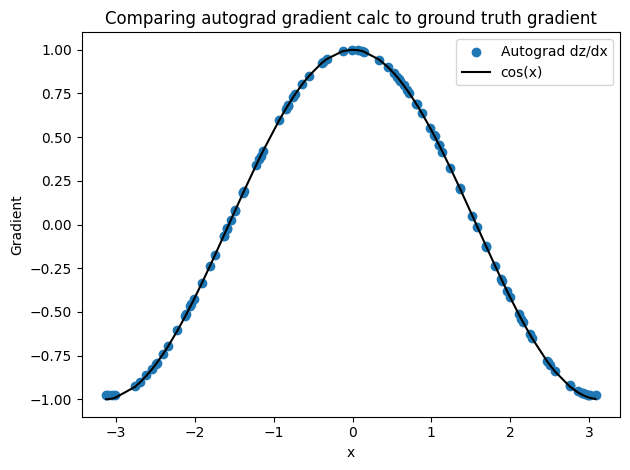

In [21]:
# 1d

# Using the same variables from 1c
dzdx = x.grad.cpu().numpy()

plt.figure()
plt.scatter(x_npy, dzdx, label="Autograd dz/dx")
plt.plot(np.sort(x_npy), np.cos(np.sort(x_npy)), label="cos(x)", color='black')
plt.xlabel("x")
plt.ylabel("Gradient")
plt.title("Comparing autograd gradient calc to ground truth gradient")
plt.legend()
plt.tight_layout()
plt.show()


### Problem 1.2: Image Denoising

In [ ]:
"""
Returns the x and y gradient images for input image I.
Input:
I: (Tensor) Image of shape (H, W, 3)

Output:
(Ix, Iy): (Tensor) Gradient images each of shape (H, W, 3)
"""
def get_spatial_gradients(I):
  I = I.permute(2, 0, 1).unsqueeze(0) # Change I's shape from (H, W, 3) to (1, 3, H, W)
  kx = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)
  ky = torch.zeros(I.shape[1], I.shape[1], 3, 3).to(I.device)

  for i in range(3):
    kx[i, i, 1, 1] = -1
    kx[i, i, 1, 2] = 1
    ky[i, i, 1, 1] = -1
    ky[i, i, 2, 1] = 1

  Ix = F.conv2d(I, kx, padding=1)
  Iy = F.conv2d(I, ky, padding=1)
  return Ix[0,...].permute(1,2,0), Iy[0,...].permute(1,2,0)

"""
Denoising objective function.
Input:
I, J: (Tensor) Images of shape (H, W, 3)
alpha: (float) Regularization hyperparameter

Output:
loss: (Tensor[float])
"""
def denoising_loss(I, J, alpha):
  return None # Replace with your code for 1.2a.

In [ ]:
img = imageio.imread('parrot_noisy.png') / 255.0
I = torch.tensor(img, dtype=torch.float32)
I = I.to('cuda')

lr = None # Learning rate
alpha = None # alpha
n_iter = None # Number of iterations

for i in range(n_iter):
  # Your code for 1.2b goes here

  with torch.no_grad():
    pass # Replace with your code for 1.2b

## Problem 2: Training an Image Classifier

### 2a: Finish implementing dataset class

In [ ]:
class CIFARDataset(Dataset):
  def __init__(self, images, labels, mode, transform):
    self.transform = transform

    if mode == 'train':
      pass # Your code here. If training, use examples [0,40000) of the
      # entire dataset

    elif mode == 'val':
      pass # Your code here. If validation, use examples [40,000-50,000)
      # of the entire dataset

    elif mode == 'test':
      pass # Your code here. If testing, use examples [50,000-60,000) of the
      # entire dataset

    else:
      raise ValueError('Invalid mode!')

  def __getitem__(self, idx):
    # Do the following:
    # 1. Get the image and label from the dataset corresponding to index idx.
    # 2. Convert the label to a LongTensor (needs to be of this type because it
    # is an integer value and PyTorch will throw an error otherwise)
    # 3. Transform the image using self.transform. This will convert the image
    # into a tensor, scale it to [0,1], and apply data augmentations.
    # 4. Return the image and label.
    return None

  def __len__(self):
    return None # Replace with your code.

### 2b: Write transforms

In [ ]:
cifar = np.load('/content/drive/MyDrive/CIFAR.npz')
X, y, label_names = cifar['X'], cifar['y'] * 1.0, cifar['label_names']
print("Read in CIFAR10 dataset with %d examples, and labels:\n %s" % (X.shape[0], label_names))

batch_size = 64

transform = None # Add transforms.
train_dataset = CIFARDataset(X, y, "train", transform)
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = None # No transforms, but should still include ToTensor().
val_dataset = CIFARDataset(X, y, "val", transform)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

transform = None # No transforms, but should still include ToTensor().
test_dataset = CIFARDataset(X, y, "test", transform)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

### 2c: Implement the model

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    pass #Replace with your code

  def forward(self, x):
    return x #Replace with your code

### 2d/2e: Implement the training loop, and train your model.

In [ ]:
# Your code here. Don't forget to call model.train() before training!

### 2f: Choose the best model based on overall accuracy
using the validation dataset.

In [ ]:
# Your code here. Don't forget to call model.eval() first!

### 2g: Implement code for computing overall accuracy, accuracy per class, and the confusion matrix on the test set.

In [ ]:
# Your code here. Don't forget to call model.eval() first!

## Problem 3: Run Mask R-CNN with Detectron2

In [ ]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).

import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [ ]:
# import libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# load image
im = cv2.imread("image path")
cv2_imshow(im)

In [ ]:
# Load pre-trained model
# You can find the model cofig from the following url, or other config of your choice
# https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-Detection
# https://github.com/facebookresearch/detectron2/tree/main/configs/COCO-InstanceSegmentation

##### Your code #####
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("your choice of pretrained model"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Your choice of pretrained model")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST =   # set threshold for this model (0-1)

In [ ]:
# Create predictor
predictor = DefaultPredictor(cfg)
# Run inference on the sample image
outputs = predictor(im)

In [ ]:
# Visualize results with "Visualizer"
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Problem 4: Adversarial attacks for trained networks. Wite code below

In [ ]:
def fgsm_attack(model, image, eps):
  # Your code here.

In [ ]:
# Your code here for creating and displaying adversarial images.